In [1]:
import pandas as pd
import warnings
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

warnings.filterwarnings('ignore')

url = "https://raw.githubusercontent.com/kevirui/challenge-telecom-x/refs/heads/ramaDev/data/data_tratada.csv"

data = pd.read_csv(url)

# Tratamiento y Codificación

In [2]:
data = data.drop(columns=['customerID', 'account.Charges.Total', 'Total.Day'])

```bash
data['customer.Partner'] = data['customer.Partner'].replace({'No':0, 'Yes':1}).astype(int)
data['customer.Dependents'] = data['customer.Dependents'].replace({'No':0, 'Yes':1}).astype(int)
data['account.PaperlessBilling'] = data['account.PaperlessBilling'].replace({'No':0, 'Yes':1}).astype(int)
```

```bash
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categoricas = ['customer.gender', 'account.Contract', 'account.PaymentMethod']

one_hot_enc = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), categoricas), remainder='passthrough')
data = one_hot_enc.fit_transform(data)
data = pd.DataFrame(data, columns=one_hot_enc.get_feature_names_out())
data.sample(5)
```

In [3]:
def preproceso(df):
    data = df.copy()

    # Diccionario de reemplazos para binarias
    reemplazos = {
        'Yes': 1,
        'No': 0,
        'No phone service': 0,
        'No internet service': 0
    }

    # Columnas binarias
    binarios = [
        'Churn', 'customer.Partner', 'customer.Dependents',
        'phone.PhoneService', 'phone.MultipleLines', 'internet.OnlineSecurity',
        'internet.OnlineBackup', 'internet.DeviceProtection',
        'internet.TechSupport', 'internet.StreamingTV',
        'internet.StreamingMovies', 'account.PaperlessBilling'
    ]

    # Columnas nominales
    nominales = ['customer.gender', 'account.Contract', 'account.PaymentMethod', 'internet.InternetService']

    # Procesar binarias
    for col in binarios:
        if col in data.columns:
            data[col] = data[col].replace(reemplazos).astype(int)

    # One-Hot Encoding para nominales
    data = pd.get_dummies(data, columns=nominales, drop_first=True)

    return data

data_procesada = preproceso(data)

In [4]:
data_procesada['Churn'].value_counts()

,count
Churn,
0,5174
1,1869


In [5]:
data_procesada['Churn'].value_counts(normalize=True)

,proportion
Churn,
0,0.73463
1,0.26537


Hay desbalance de clases en relación a la evasión

# Balanceo de datos

In [6]:
x, y = data_procesada.drop(columns=['Churn']), data_procesada['Churn']

In [7]:
from collections import Counter

print(sorted(Counter(y).items()))

[(0, 5174), (1, 1869)]


Existe desbalanceo de datos

( Aplicare under sampling )

In [8]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=5)
x_bal, y_bal = smote_enn.fit_resample(x, y)

In [9]:
print(sorted(Counter(y_bal).items()))

[(0, 2627), (1, 4132)]


# Normalización

In [10]:
data_procesada.describe().round(2)

,Churn,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.PaperlessBilling,account.Charges.Monthly
count,7043.00,7043.00,7043.00,7043.00,7043.00,7043.0,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00
mean,0.27,0.16,0.48,0.30,32.37,0.9,0.42,0.29,0.34,0.34,0.29,0.38,0.39,0.59,64.76
std,0.44,0.37,0.50,0.46,24.56,0.3,0.49,0.45,0.48,0.48,0.45,0.49,0.49,0.49,30.09
min,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.25
25%,0.00,0.00,0.00,0.00,9.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,35.50
50%,0.00,0.00,0.00,0.00,29.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,70.35
75%,1.00,0.00,1.00,1.00,55.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,89.85
max,1.00,1.00,1.00,1.00,72.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,118.75


Usaremos Random Forest - Decision Tree - KNNeighbors, por lo tanto normalizar no es necesario ya que no es sensible a los datos. Solamente para KNNeighbots.

## Normalizar para KNNeighbors

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_bal_norm = scaler.fit_transform(x_bal)

# Analisis de Correlación

In [13]:
churnCorr = data_procesada.corr()['Churn']
churnCorr = churnCorr.drop('Churn')

churnCorr = churnCorr.abs().sort_values(ascending=False)

print("Variables con las correlaciones más fuertes con 'Churn' (ordenadas por valor absoluto):")
display(churnCorr)

Variables con las correlaciones más fuertes con 'Churn' (ordenadas por valor absoluto):


,Churn
customer.tenure,0.352229
internet.InternetService_Fiber optic,0.308020
account.Contract_Two year,0.302253
account.PaymentMethod_Electronic check,0.301919
internet.InternetService_No,0.227890
account.Charges.Monthly,0.193356
account.PaperlessBilling,0.191825
account.Contract_One year,0.177820
internet.OnlineSecurity,0.171226
internet.TechSupport,0.164674


# Análisis Dirigido

## Tiempo de Contrato x Cancelación

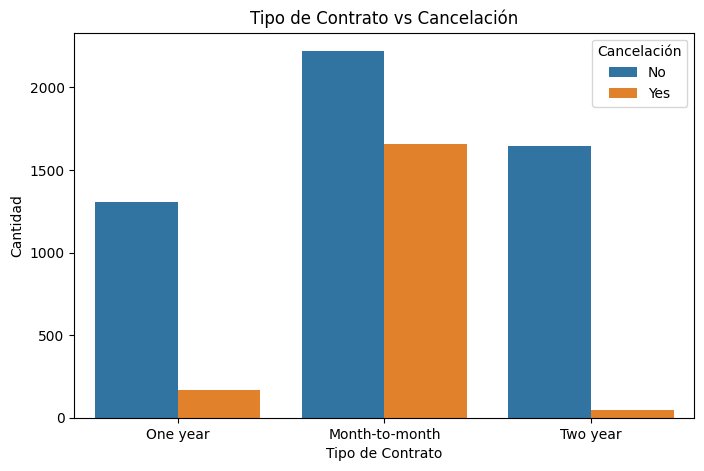

In [20]:
plt.figure(figsize=(8,5))
sns.countplot(x='account.Contract', hue='Churn', data=data)
plt.title('Tipo de Contrato vs Cancelación')
plt.xlabel("Tipo de Contrato")
plt.ylabel("Cantidad")
plt.legend(title='Cancelación')
plt.show()

- Los tipos de contrato mes a mes indican que son mas propensos a cancelar
- En cambio los tipos de contrato cada 2 años son menos propensos a cancelar

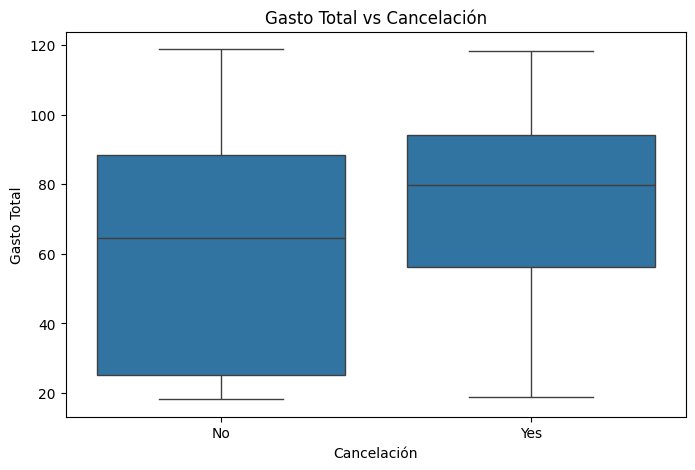

In [27]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='account.Charges.Monthly', data=data)
plt.title('Gasto Total vs Cancelación')
plt.xlabel("Cancelación")
plt.ylabel("Gasto Total")
plt.show()

- El promedio de gastos totales de los que cancelan tienen un gasto mayor que a los minimos habituales.
- Muchas de las cancelaciones cuentan con los gastos rondando en 80 y 60

# Selección de variables

# Entrenamientos de modelos

## Entrenamiento modelo baseline

## Entrenamiento Random Forest

## Entrenamiento Decision Tree

# Evaluar Modelos

# Interpretación

# Conclusión

Principales factores que influyen en el churn ( la evasión del cliente ):
- 1
- 2